In [86]:
import os
import torch
import shutil
import webcolors
import numpy as np
import pandas as pd
from tqdm import tqdm
from easydict import EasyDict
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from util.dataset import TrashDataset
import segmentation_models_pytorch as smp
from util.augmentation import get_valid_transform
from util.metrics import add_hist, label_accuracy_score

# args 세팅

In [8]:
args = EasyDict({
    "total_json": "/opt/ml/input/data/train_all.json",
    "train_json": "/opt/ml/input/data/train.json",
    "valid_json": "/opt/ml/input/data/val.json",
    "test_json": "/opt/ml/input/data/test.json",
    "device": "cuda",
    "learning_rate": 0.0001,
    "batch_size": 1,
    "num_workers": 2,
    "save_dir": "/opt/ml/input/seunghyun/competition/val_checker/mask",
    "model_path": "/opt/ml/input/level2-semantic-segmentation-level2-cv-11/pytorch/saved/EPOCH_30_DeepLabV3Plus_efficientb3_pretrained.pt",
})
class_colormap = pd.read_csv("/opt/ml/input/code/class_dict.csv")
category_names = ['Background',
                  'General trash',
                  'Paper',
                  'Paper pack',
                  'Metal',
                  'Glass',
                  'Plastic',
                  'Styrofoam',
                  'Plastic bag',
                  'Battery',
                  'Clothing']


# 1. Load Model

In [9]:
model = smp.DeepLabV3Plus(
            encoder_name = 'timm-efficientnet-b3', # timm-efficientnet-b3
            encoder_weights = 'imagenet',
            in_channels=3,
            classes = 11
        )

In [10]:
# best model 불러오기
checkpoint = torch.load(args.model_path, map_location=args.device)
model.load_state_dict(checkpoint["state_dict"])

model = model.to(args.device)
# 추론을 실행하기 전에는 반드시 설정 (batch normalization, dropout 를 평가 모드로 설정)
model.eval();

# 2. Load valid data

In [11]:
def collate_fn(batch):
    return tuple(zip(*batch))

val_dataset = TrashDataset(data_dir=args.valid_json, mode='val', transform=get_valid_transform(args))
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                        batch_size=args.batch_size,
                                        shuffle=False,
                                        num_workers=args.num_workers,
                                        collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.98s)
creating index...
index created!


# 3. compute IoU

In [12]:
def create_trash_label_colormap():
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, (_, r, g, b) in enumerate(class_colormap.values):
        colormap[inex] = [r, g, b]
    
    return colormap

def label_to_color_image(label):
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

### 폴더 생성

In [26]:
if not os.path.exists(args.save_dir):
    os.makedirs(args.save_dir)

In [36]:
# variable for legend
category_and_rgb = [[category, (r,g,b)] for idx, (category, r, g, b) in enumerate(class_colormap.values)]
legend_elements = [Patch(facecolor=webcolors.rgb_to_hex(rgb), 
                         edgecolor=webcolors.rgb_to_hex(rgb), 
                         label=category) for category, rgb in category_and_rgb]

total_fnames = []
total_mIoU = []
total_class_nums = []

pbar = tqdm(val_loader, total=len(val_loader), desc=f"Valid")
for index, (imgs, masks, image_infos) in enumerate(pbar):
    
    f_name = image_infos[0]['file_name']
    if not os.path.exists(os.path.join(args.save_dir, f_name.split('/')[0])):
        os.makedirs(os.path.join(args.save_dir, f_name.split('/')[0]))
        
    outs = model(torch.stack(imgs).to(args.device))
    # loss(outs, masks) crossentropy(class=weight). backgorund=0.2 0.1) + dice loss
    oms = torch.argmax(outs, dim=1).detach().cpu().numpy()
    
    masks = torch.stack(masks).long()
    
    hist = np.zeros((11, 11))
    hist = add_hist(hist, masks.detach().cpu().numpy(), oms, n_class=11)
    acc, acc_cls, mIoU, fwavacc, IoU = label_accuracy_score(hist)
    # print(f"mIoU: {round(mIoU,4)} mean IoU: {round(np.nanmean(IoU),4)} acc: {round(acc,4)} acc_cls: {round(acc_cls,4)}")
    
    total_fnames.append(f_name.split(".")[0] + '.png')
    total_mIoU.append(mIoU)
    total_class_nums.append(len(masks[0].unique()))
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), constrained_layout=True)
    fig.tight_layout()

    my_suptitle = fig.suptitle(f"{f_name.split('.')[0] + '.png'} / mIoU: {round(mIoU,4)}",y=1.1)
    # Original Image
    ax[0].imshow(imgs[0].permute([1,2,0]))
    ax[0].set_title(f"Orignal Image")

    # Groud Truth
    ax[1].imshow(label_to_color_image(masks[0].detach().cpu().numpy()))
    ax[1].set_title(f"Groud Truth")

    # Pred Mask
    ax[2].imshow(label_to_color_image(oms[0]))
    ax[2].set_title(f"Pred Mask")
    my_legend = ax[2].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    
    save_path = os.path.join(args.save_dir, f_name.split(".")[0]+'.png')
    fig.savefig(save_path, bbox_inches='tight',bbox_extra_artists=[my_suptitle, my_legend])
    plt.close(fig)


Valid:   0%|          | 0/655 [00:00<?, ?it/s]/tmp/ipykernel_25679/2350939568.py:33: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()
Valid: 100%|██████████| 655/655 [06:06<00:00,  1.79it/s]


In [85]:
outs.shape

torch.Size([1, 11, 512, 512])

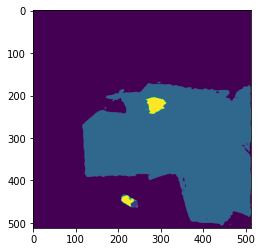

In [83]:
plt.imshow(oms[0])

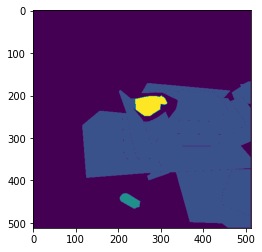

In [80]:
plt.imshow(masks[0].numpy())

# 4. Dataframe

In [58]:
df = pd.DataFrame({'file_name': total_fnames,
                  'mIoU': total_mIoU,
                  'class_nums': total_class_nums})
df = df.sort_values(by='mIoU').reset_index(drop=True)

In [59]:
df

,file_name,mIoU,class_nums
0,batch_01_vt/0589.png,0.101000,2
1,batch_01_vt/0655.png,0.122231,5
2,batch_01_vt/0558.png,0.136506,4
3,batch_03/0139.png,0.153990,3
4,batch_03/0512.png,0.162049,6
...,...,...,...
650,batch_01_vt/0572.png,0.994069,2
651,batch_01_vt/1097.png,0.994129,2
652,batch_01_vt/0400.png,0.994987,2
653,batch_03/0541.png,0.995610,2


In [60]:
# df.to_csv("DeepLabV3Plus_efficientb3_testmIoU0.5772.csv", index=False)

# sorted 폴더에 순서대로 저장

In [74]:
if not os.path.exists(os.path.join(args.save_dir, 'sorted')):
    os.makedirs(os.path.join(args.save_dir, 'sorted'))
for i, f in tqdm(enumerate(df['file_name']), total=df.shape[0]):
    src = os.path.join(args.save_dir, f)
    f = f.split('/')[-1]
    shutil.copy(src, f"{args.save_dir}/sorted/{i:0>3}_{f}")


100%|██████████| 655/655 [00:00<00:00, 2746.70it/s]
